# Getting started

Ontology based atomic structure creation, manipulation, querying.

Imports

In [1]:
from pyscal_rdf import StructureGraph

First we create a graph

In [2]:
g = StructureGraph()

## Creation of structures

We will create three structures for the demonstration.

First a BCC Iron structure

In [3]:
struct_Fe = g.create.element.Fe()

Note that when the structure is created, it is also added to the Graph automatically. We can visualise the graph.

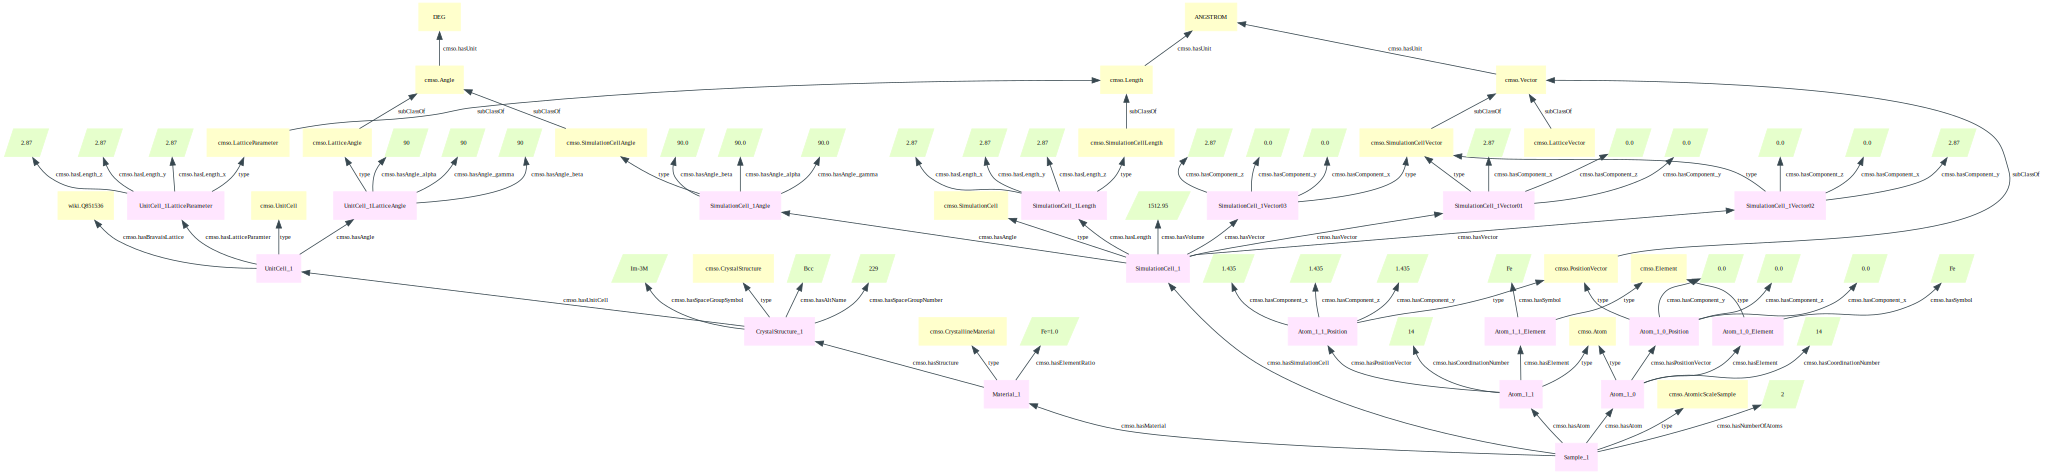

In [4]:
g.visualise(backend='graphviz')

Now a Si diamond structure

In [5]:
struct_Si = g.create.element.Si()

Finally, an L12 $Ni_3 Al$ structure

In [6]:
struct_l12 = g.create.lattice.l12(element=['Al', 'Ni'], 
                         lattice_constant=3.57)

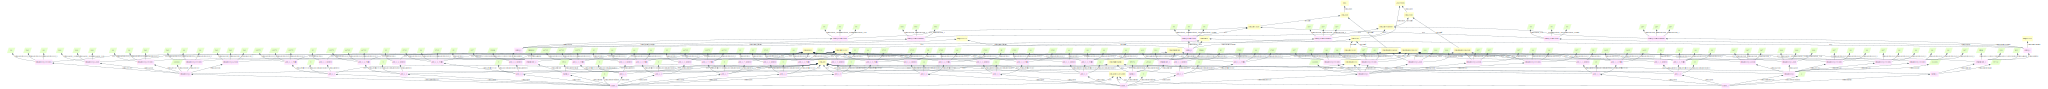

In [7]:
g.visualise(backend='graphviz')

We can save the graph and reload it as needed

## Querying the graph

An example question would be, **what are the space group of all structures with 4 atoms?**


The corresponding SPARQL query looks like this:

In [8]:
query = """
PREFIX cmso: <http://purls.helmholtz-metadaten.de/cmso/>
SELECT DISTINCT ?symbol
WHERE {
    ?sample cmso:hasNumberOfAtoms ?number .
    ?sample cmso:hasMaterial ?material .
    ?material cmso:hasStructure ?structure .
    ?structure cmso:hasSpaceGroupSymbol ?symbol .
FILTER (?number="4"^^xsd:integer)
}"""

In [9]:
res = g.query(query)

And print the results

In [10]:
res

,symbol
0,Pm-3m


The query system can also be used without experience in SPARQL, or deep knowledge about the ontology terms. For example, **What are all the samples with Bravais lattice bcc?**

First how this looks like:

In [11]:
res = g.query_sample(g.ontology.terms.cmso.hasAltName, 
             condition=(g.ontology.terms.cmso.hasAltName=='bcc'))
res

,hasAltNamevalue,AtomicScaleSample
0,bcc,Sample_1


As expected, there is only one sample, since Fe is the only bcc structure we added. We can extract the sample

In [13]:
sample = res.AtomicScaleSample[0]

We can write this sample to a file, for example, a LAMMPS data format, to use it for further simulations

In [14]:
g.to_file(sample, 'bcc.data', format="lammps-data")

In [15]:
! more bcc.data

bcc.data (written by ASE) 

2 	 atoms 
1  atom types
0.0      2.8700000000000001  xlo xhi
0.0      2.8700000000000001  ylo yhi
0.0      2.8700000000000001  zlo zhi


Atoms 

     1   1                       0                       0                      
 0
     2   1      1.4350000000000001      1.4350000000000001      1.43500000000000
01


We can also export as an ASE object

In [16]:
aseobj = g.to_file(sample, format="ase")

In [17]:
aseobj

Atoms(symbols='Fe2', pbc=True, cell=[2.87, 2.87, 2.87])